# Modified 3D PMRNN

## Module Imports

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
import cv2
import numpy as np
import matplotlib.pyplot as plt
# from CONFIGURATION import CONFIGURATION
from Reconstruction import Reconstruction

In [2]:
# ignorable
print("TensorFlow version:", tf.__version__)
print("cv2 version:",cv2.__version__)
print("np version:",np.__version__)

TensorFlow version: 2.5.0
cv2 version: 4.5.3
np version: 1.19.5


In [3]:
# ignorable
import sklearn, matplotlib
print("matplotlib version:",matplotlib.__version__)
print("sklearn version:",sklearn.__version__)

matplotlib version: 3.3.4
sklearn version: 1.2.2


In [4]:
from tensorflow.keras import layers,losses #,Sequential,metrics
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import * 
# from tensorflow.keras.layers import Layer
# from tensorflow.keras import optimizers 
# from tensorflow.keras.optimizers.experimental import SGD
# from tensorflow.image import ssim

In [5]:
CONFIGURATION = {
    "BATCH_SIZE": 16,
    "LEARNING_RATE": 0.003670944375415099,
    "OPTIMIZER":'RMSprop',
    "N_EPOCHS": 40,
    "N_FILTERS": 8,
    "INPUT_SHAPE":(256,256,1),
    "LATENT_SPACE_DIM" : 64,
    "REDUCED_DIMENSION" : 256,
}

## Load new Data

### reading data

In [ ]:
import Utils
image_data = Utils.read_data("Berea_2d25um_binary.raw")
image_data.shape

### Voxel extraction 

In [ ]:
voxels = Utils.extract_subvolumes(image_data)
voxels.shape

In [ ]:
del image_data

### Train and test data extraction

In [ ]:
X_train = voxels[:-6]
X_test = voxels[-6:]

In [ ]:
del voxels

In [ ]:
len(X_train)

### Save Traited data for uses

In [ ]:
with open('X_train.npy', 'wb') as f:
    np.save(f, X_train)

In [ ]:
with open('X_test.npy', 'wb') as f:
    np.save(f, X_test)

## TensorFlow GPU setup

In [6]:
#from tensorflow.python.compiler.tensorrt import trt_convert as trt
device = tf.config.list_physical_devices("GPU")
print(device)  # Check if GPU devices are visible
print(tf.test.is_built_with_cuda())  # Check if TensorFlow is built with CUDA support
#print(trt.trt_utils._pywrap_py_utils.get_linked_tensorrt_version())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [7]:
# only on weak GPU
tf.config.experimental.set_memory_growth(device[0],True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [7]:
tf.keras.backend.clear_session()

## Load Traited data for training (voxels)

In [8]:
X_train=np.load('X_train.npy')
X_train.shape

(58, 250, 256, 256, 1)

In [8]:
X_test=np.load('X_test.npy')
X_test.shape

(6, 250, 256, 256, 1)

### idk

In [9]:
learnedVoxels = []
inferenceVoxels = []
for voxel in X_train:
    learnedVoxels.append(voxel[:-1])
    inferenceVoxels.append(voxel[1:])

# learnedVoxels = np.array(learnedVoxels)
# inferenceVoxels = np.array(inferenceVoxels)

## Training 

### Imports

In [10]:
from mealpy.swarm_based import GWO
from sklearn.preprocessing import LabelEncoder
import time
from datetime import datetime

### Lables

In [11]:
class Timer():
    def __init__(self,title=" ") -> None:
        self.title=title
        self.started=time.time()
        print(f"{self.title} Started at : {datetime.fromtimestamp(self.started)}")
        self.ended=None
    def End(self):
        self.ended=time.time()
        print(f"{self.title} Ended at : {datetime.fromtimestamp(self.ended)} and it took {self.ended-self.started}s")
    def toDuration(self):
        if self.ended == None:
            return -1
        return self.ended-self.started
    def __str__(self) -> str:
        return f"{self.title} Started at : {datetime.fromtimestamp(self.started)} | Ended at : {datetime.fromtimestamp(self.ended)} and it took {self.ended-self.started}s"

class TrainingTime(Timer):
    def __init__(self,title=" ") -> None:
        super().__init__(title=title)
        self.samples=[]

    def SampleStarted(self,title=" ")->Timer:
        timer= Timer(title)
        self.samples.append(timer)
        return timer
    

In [9]:
from tensorflow.keras import layers, losses  # ,Sequential,metrics
from tensorflow.keras.models import Model
from CBAM import ConvolutionBlockAttentionModule
from tensorflow import reduce_mean, abs
from tensorflow.keras.optimizers import *

import os
import pickle




def calculate_kl_loss(model):
    def _calculate_kl_loss(*args):
        kld = losses.KLDivergence()
        kl_loss = kld(model.inferenceDistribution, model.learnedDistribution)
        return abs(kl_loss)
    return _calculate_kl_loss


def _calculate_reconstruction_loss(y_target, y_predicted):
    mse = losses.MeanSquaredError()
    reconstruction_loss = mse(y_target, y_predicted)
    return reconstruction_loss

# def _calculate_reconstruction_loss(y_target, y_predicted):
#     ssim_loss = 1 - reduce_mean(ssim(y_target, y_predicted, max_val=1.0))
#     return ssim_loss


def _calculate_porosity_loss(y_target, y_predicted):
    por1 = reduce_mean(y_target, axis=(1, 2))
    por2 = reduce_mean(y_predicted, axis=(1, 2))
    mae = losses.MeanAbsoluteError()
    return mae(por1, por2)


class Reconstruction():
    """
    Reconstruction represents a Deep Convolutional variational autoencoder architecture
    with mirrored encoder and decoder components.
    """

    def __init__(self,
                 inputShape=CONFIGURATION["INPUT_SHAPE"],
                 latent_space_dim=CONFIGURATION["LATENT_SPACE_DIM"],
                 reducedDimension=CONFIGURATION["REDUCED_DIMENSION"],
                 num_conv_layers=CONFIGURATION["N_FILTERS"],
                 learning_rate=CONFIGURATION["LEARNING_RATE"],
                 batch_size=CONFIGURATION["BATCH_SIZE"],
                 epochs=CONFIGURATION["N_EPOCHS"],
                 opt=CONFIGURATION["OPTIMIZER"],
                 ) -> None:

        ##### inputs ######
        self.inputShape = inputShape  # [256, 256, 1]
        self.latent_space_dim = latent_space_dim  # 64
        self.reducedDimension = reducedDimension  # 256
        self.num_conv_layers = num_conv_layers  # 5
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.opt = opt
#         self.optimizer = getattr(optimizers, opt)(lr = learning_rate)
        self.optimizers = {
            'SGD': SGD,
            'RMSprop': RMSprop,
            'Adagrad': Adagrad,
            'Adadelta': Adadelta,
            'Adam': Adam,
            'Adamax': Adamax,
            'Nadam': Nadam,
        }
        self.reshapeDims = self.inputShape[0] // 2**self.num_conv_layers
        self.last_filter = 16 * 2 ** (self.num_conv_layers-1)

        ##### Loss weights ######
        self.reconstruction_loss_weight = 1
        self.Kullback_leibler_weight = 0.001
        self.porosity_Loss_weight = 1

        self.skipConnections = None

        self.learnedPrior = None
        self.inference = None
        self.Generate = None
        self.Reconstruction = None

        self.skipConnections = []

        self.learnedDistribution = None
        self.inferenceDistribution = None

        self._build()

    def summary(self):
        self.learnedPrior.summary()
        self.inference.summary()
        self.Generate.summary()
        self.Reconstruction.summary()

    def compile(self):
        optimizer = self.optimizers[self.opt](learning_rate=self.learning_rate)
        self.Reconstruction.compile(optimizer=optimizer,
                                    loss=self._calculate_combined_loss,
                                    metrics=[_calculate_reconstruction_loss,
                                             _calculate_porosity_loss,
                                             calculate_kl_loss(self)],
                                    experimental_run_tf_function=False)

    def train(self, inputs1, inputs2):
        return self.Reconstruction.fit(x=[inputs1, inputs2],
                                       y=inputs2,
                                       batch_size=self.batch_size,
                                       epochs=self.epochs,
                                       )

    def save(self, save_folder="."):
        self._create_folder_if_it_doesnt_exist(save_folder)
        self._save_parameters(save_folder)
        self._save_weights(save_folder)

    def load_weights(self, weights_path):
        self.Reconstruction.load_weights(weights_path)

    def reconstruct(self, images):
        latent_representations = self.encoder.predict(images)
        reconstructed_images = self.decoder.predict(latent_representations)
        return reconstructed_images, latent_representations

    @classmethod
    def load(cls, save_folder="."):
        parameters_path = os.path.join(save_folder, "parameters.pkl")
        with open(parameters_path, "rb") as f:
            parameters = pickle.load(f)
        reconstruction = Reconstruction(*parameters)
        weights_path = os.path.join(save_folder, "weights.h5")
        reconstruction.load_weights(weights_path)
        return reconstruction

    def _create_folder_if_it_doesnt_exist(self, folder):
        if not os.path.exists(folder):
            os.makedirs(folder)

    def _save_parameters(self, save_folder):
        parameters = [
            self.inputShape,
            self.latent_space_dim,
            self.reducedDimension,
            self.num_conv_layers,
            self.learning_rate,
            self.batch_size,
            self.epochs,
            self.opt,
        ]
        save_path = os.path.join(save_folder, "parameters.pkl")
        with open(save_path, "wb") as f:
            pickle.dump(parameters, f)

    def _save_weights(self, save_folder):
        save_path = os.path.join(save_folder, "weights.h5")
        self.Reconstruction.save_weights(save_path)

    def _calculate_combined_loss(self, y_target, y_predicted):

        reconstruction_loss = _calculate_reconstruction_loss(
            y_target, y_predicted)
        kl_loss = calculate_kl_loss(self)(
            self.inferenceDistribution, self.learnedDistribution)
        porisity_loss = _calculate_porosity_loss(y_target, y_predicted)
        combined_loss = self.reconstruction_loss_weight * reconstruction_loss\
            + kl_loss * self.Kullback_leibler_weight\
            + porisity_loss * self.porosity_Loss_weight
        return combined_loss

    def _build(self):
        self._build_inference(self.num_conv_layers)
        self._build_learned_prior(self.num_conv_layers)
        self._build_generate(self.num_conv_layers)
        self._build_reconstruction()

    ######  inference ########

    def _build_inference(self, num_conv_layers):
        inference_input = layers.Input(
            shape=self.inputShape, name="inference_input")

        # ------------------------------------ Encoder ---------------------------------------------

        x = inference_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu',
                                 padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp

        flattened = layers.Flatten()(x)

        latentDense = layers.Dense(
            self.reducedDimension, name="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)

        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        inferenceDist = layers.LSTM(
            self.latent_space_dim, return_sequences=True, name="inference_LSTM")(reshaped)

        self.inference = Model(
            inference_input, inferenceDist, name="inference")

    ######   learned prior ########

    def _build_learned_prior(self, num_conv_layers):
        learned_input = layers.Input(
            shape=self.inputShape, name="learned_prior_input")

        # ------------------------------------ Encoder ---------------------------------------------

        x = learned_input
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu',
                                 padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp

        flattened = layers.Flatten()(x)

        latentDense = layers.Dense(
            self.reducedDimension, name="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)

        reshaped = layers.Reshape((1, self.reducedDimension))(conv_out)
        learned_dist = layers.LSTM(
            self.latent_space_dim, return_sequences=True, name="learned_LSTM")(reshaped)
        self.learnedPrior = Model(
            learned_input, learned_dist, name="learned_prior")

    #### generate ######

    def _build_generate(self, num_conv_layers):

        input_generate = layers.Input(
            shape=self.inputShape, name="generate_input")
        learnedDist = layers.Input(
            shape=(1, self.latent_space_dim), name="gen_learned_input")

        # ------------------------------------ Encoder ---------------------------------------------

        x = input_generate
        for i in range(num_conv_layers):
            conv = layers.Conv2D(16 * 2 ** i, (3, 3), activation='relu',
                                 padding='same', name=f"encoder_conv_{i+1}")(x)
            bn = layers.BatchNormalization()(conv)
            mp = layers.MaxPooling2D((2, 2), padding='same')(bn)
            x = mp
            self.skipConnections.append(bn)

        flattened = layers.Flatten()(x)

        latentDense = layers.Dense(
            self.reducedDimension, name="latent_dense")(flattened)
        conv_out = layers.BatchNormalization()(latentDense)

        temp = layers.Reshape((1, self.reducedDimension))(conv_out)

        concated_input = layers.Concatenate(axis=-1)([temp, learnedDist])

        reshaped = layers.Reshape(
            (1, self.reducedDimension + self.latent_space_dim))(concated_input)

        generated = layers.LSTM(
            self.reducedDimension, return_sequences=True, name="generate_LSTM")(reshaped)

        # ------------------------------------ Decoder ---------------------------------------------

        upDense = layers.Dense(
            self.reshapeDims*self.reshapeDims*self.last_filter, name="up_dense")(generated)
        batchNorm_7 = layers.BatchNormalization()(upDense)

        reshapedUp = layers.Reshape(
            (self.reshapeDims, self.reshapeDims, self.last_filter))(batchNorm_7)

        generated = reshapedUp
        for i in reversed(range(num_conv_layers)):
            convT = layers.Conv2DTranspose(16 * 2 ** i, (3, 3), strides=2, activation='relu',
                                           padding='same', name=f"decoder_conv_{i+1}")(generated)
            bn = layers.BatchNormalization()(convT)
            skip_conn = self.skipConnections.pop()
            bn = layers.Add()([bn, skip_conn])
            generated = ConvolutionBlockAttentionModule()(bn)

        gen_out = layers.Conv2DTranspose(
            1, (3, 3), activation='sigmoid', padding='same')(generated)

        self.Generate = Model(
            [input_generate, learnedDist], gen_out, name="generate")

    def _build_reconstruction(self):
        input_learned = layers.Input(
            shape=self.inputShape, name="learned_input")
        input_inference = layers.Input(
            shape=self.inputShape, name="inference_input")

        self.learnedDistribution = self.learnedPrior(input_learned)
        self.inferenceDistribution = self.inference(input_inference)
        gen_out = self.Generate([input_learned, self.learnedDistribution])

        self.Reconstruction = Model(
            [input_learned, input_inference], gen_out, name="reconstuction")


In [10]:
reconstruction = Reconstruction()
reconstruction.summary()
reconstruction.compile()

Instructions for updating:
Colocations handled automatically by placer.
Model: "learned_prior"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
learned_prior_input (InputLa [(None, 256, 256, 1)]     0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 256, 256, 16)      160       
_________________________________________________________________
batch_normalization_9 (Batch (None, 256, 256, 16)      64        
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_______________________________________________

In [12]:
OPT_ENCODER = LabelEncoder()
#OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam'])
OPT_ENCODER.fit(['SGD', 'RMSprop', 'Adagrad', 'Adam'])
trainings_duration=[]

### Solution Decodation function

In [13]:
def decode_solution(solution):
    batch_size = 2**int(solution[0])
    
    learning_rate = solution[1]
    
    opt_int = int(solution[2])
    opt = OPT_ENCODER.inverse_transform([opt_int])[0]
    
    epoch = 10 *int(solution[3])
    
    num_filters = int(solution[4])
    
    latent_space_dim = 2**int(solution[5])
    
    reduced_dim = 2**int(solution[6])
    
    return [batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim,reduced_dim]

### Objective Function

In [14]:
def objective_function(solution):
    tf.keras.backend.clear_session()
    batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim = decode_solution(solution)
    reconstruction = Reconstruction(inputShape=CONFIGURATION["INPUT_SHAPE"],
                                     latent_space_dim = latent_space_dim,
                                     reducedDimension = reduced_dim,
                                     num_conv_layers = num_filters,
                                     learning_rate = learning_rate,
                                     batch_size = batch_size,
                                     epochs = epoch,
                                     opt = opt,
                                   )
#     reconstruction.summary()
    reconstruction.compile()
    
    trainingTime=TrainingTime("Epoch Training")
    histories = []
    for i in range(len(learnedVoxels)):
        print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
        sampleTime = trainingTime.SampleStarted(f"Voxel Training {i}")
        histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))
        sampleTime.End()
        
    trainingTime.End()
    trainings_duration.append(trainingTime)
    reconstruction.save(save_folder=f"results/model_{batch_size}_{learning_rate}_{opt}_{epoch}_{num_filters}_{latent_space_dim}_{reduced_dim}")
    
    return histories[-1].history['loss'][-1]

### Configurations

In [15]:
LB = [3    , 0.001 , 0   , 2      ,  4  ,  6    , 7 ]
UB = [5.99 , 0.01  , 3.99, 4.99  ,  8.99,  8.99 , 9.99 ]

problem_dict = {
    "fit_func": objective_function,
    "lb": LB,
    "ub": UB,
    "minmax": "min",
    "verbose":True,
}
metaheuristic_configuration={
    "epoch":5,
    "pop_size":50
}

### Lunching the metaheuristic

In [16]:
model = GWO.BaseGWO(problem_dict,epoch=metaheuristic_configuration["epoch"],pop_size=metaheuristic_configuration["pop_size"])

Instructions for updating:
Colocations handled automatically by placer.


Epoch Training Started at : 2023-06-18 03:11:06.967970
currently working one voxel : 1, voxels left : 57 
Voxel Training 0 Started at : 2023-06-18 03:11:06.968064


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Train on 249 samples


2023-06-18 03:11:11.621846: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2023-06-18 03:11:11.742132: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2023-06-18 03:11:11.945485: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.
2023-06-18 03:11:11.997315: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150994944 exceeds 10% of free system memory.


Epoch 1/20


2023-06-18 03:11:25.109995: W tensorflow/core/common_runtime/bfc_allocator.cc:343] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.


240/249 [===========================>..] - ETA: 0s - loss: 0.3752 - _calculate_reconstruction_loss: 0.1460 - _calculate_porosity_loss: 0.1969 - _calculate_kl_loss: 32.2891

2023-06-18 03:11:30.703936: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


249/249 [==============================] - 18s 71ms/sample - loss: 0.3730 - _calculate_reconstruction_loss: 0.1433 - _calculate_porosity_loss: 0.1957 - _calculate_kl_loss: 32.3856
Epoch 2/20
249/249 [==============================] - 3s 13ms/sample - loss: 0.2623 - _calculate_reconstruction_loss: 0.0849 - _calculate_porosity_loss: 0.1452 - _calculate_kl_loss: 31.8349
Epoch 3/20
249/249 [==============================] - 3s 13ms/sample - loss: 0.2153 - _calculate_reconstruction_loss: 0.0664 - _calculate_porosity_loss: 0.1162 - _calculate_kl_loss: 32.1352
Epoch 4/20
249/249 [==============================] - 3s 13ms/sample - loss: 0.1840 - _calculate_reconstruction_loss: 0.0562 - _calculate_porosity_loss: 0.0962 - _calculate_kl_loss: 31.5213
Epoch 5/20
249/249 [==============================] - 3s 13ms/sample - loss: 0.1608 - _calculate_reconstruction_loss: 0.0492 - _calculate_porosity_loss: 0.0805 - _calculate_kl_loss: 30.9051
Epoch 6/20
249/249 [==============================] - 3s 13m

2023/06/18 04:34:59 AM, INFO, mealpy.swarm_based.GWO.BaseGWO: Solving single objective optimization problem.
INFO:mealpy.swarm_based.GWO.BaseGWO:Solving single objective optimization problem.


In [ ]:
#model.solve()

In [17]:
print(f"Best solution : {model.solution[0]}")
batch_size,learning_rate,opt,epoch,num_filters,latent_space_dim ,reduced_dim = decode_solution(model.solution[0])
print(f"Batch size : {batch_size}, learning_rate : {learning_rate}, opt : {opt}, epoch : {epoch}, num_filters : {num_filters}, latent_space_dim : {latent_space_dim}, reduced_dim : {reduced_dim}")
model.history.save_global_objectives_chart(filename="hello/goc")
model.history.save_local_objectives_chart(filename="hello/loc")

model.history.save_global_best_fitness_chart(filename="hello/gbfc")
model.history.save_local_best_fitness_chart(filename="hello/lbfc")

model.history.save_runtime_chart(filename="hello/rtc")

model.history.save_exploration_exploitation_chart(filename="hello/eec")

model.history.save_diversity_chart(filename="hello/dc")

model.history.save_trajectory_chart(list_agent_idx=[3, 5], selected_dimensions=[3], filename="hello/tc")

TypeError: 'NoneType' object is not subscriptable

## Training the model

In [14]:
histories = []
for i in range(len(learnedVoxels)):
        print(f"currently working one voxel : {i +1}, voxels left : {len(learnedVoxels)-(i+1)} ")
        histories.append(reconstruction.train(learnedVoxels[i],inferenceVoxels[i]))

currently working one voxel : 1, voxels left : 57 
Train on 249 samples
Epoch 1/40
249/249 [==============================] - 22s 87ms/sample - loss: 0.1254 - _calculate_reconstruction_loss: 0.0555 - _calculate_porosity_loss: 0.0400 - _calculate_kl_loss: 27.9436
Epoch 2/40
249/249 [==============================] - 5s 22ms/sample - loss: 0.0578 - _calculate_reconstruction_loss: 0.0279 - _calculate_porosity_loss: 0.0050 - _calculate_kl_loss: 24.8164
Epoch 3/40
249/249 [==============================] - 6s 22ms/sample - loss: 0.0549 - _calculate_reconstruction_loss: 0.0278 - _calculate_porosity_loss: 0.0053 - _calculate_kl_loss: 21.9349
Epoch 4/40
249/249 [==============================] - 6s 22ms/sample - loss: 0.0535 - _calculate_reconstruction_loss: 0.0276 - _calculate_porosity_loss: 0.0049 - _calculate_kl_loss: 21.0683
Epoch 5/40
249/249 [==============================] - 6s 22ms/sample - loss: 0.0475 - _calculate_reconstruction_loss: 0.0273 - _calculate_porosity_loss: 0.0047 - _calc

In [15]:
reconstruction.save(save_folder="M-3D-PMRNN-trained")

In [8]:
tf.keras.utils.plot_model(reconstruction, to_file='M-3D-PMRNN_architecture.png', show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [11]:
reconstruction = Reconstruction.load(save_folder=f"M-3D-PMRNN-trained")

## Testing the model

### Load test data

In [11]:
X_test=np.load('X_test.npy')
X_test.shape

(6, 250, 256, 256, 1)

In [12]:
first  = X_test[0]
Topredict = first[1:]
test = first[:-1]

In [13]:
testing = []
inputLayer = first[0]
print(inputLayer.shape)
# for i in range(len(first)-1):
for i in range(len(test)):
    learned = reconstruction.learnedPrior.predict(inputLayer.reshape(1,256,256,1))
    testing.append(reconstruction.Generate.predict([inputLayer.reshape(1,256,256,1),learned.reshape(1,1,CONFIGURATION["LATENT_SPACE_DIM"])],steps=1))
    inputLayer = testing[-1]

(256, 256, 1)


d:\Anaconda\envs\PFE\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [ ]:
len(testing)

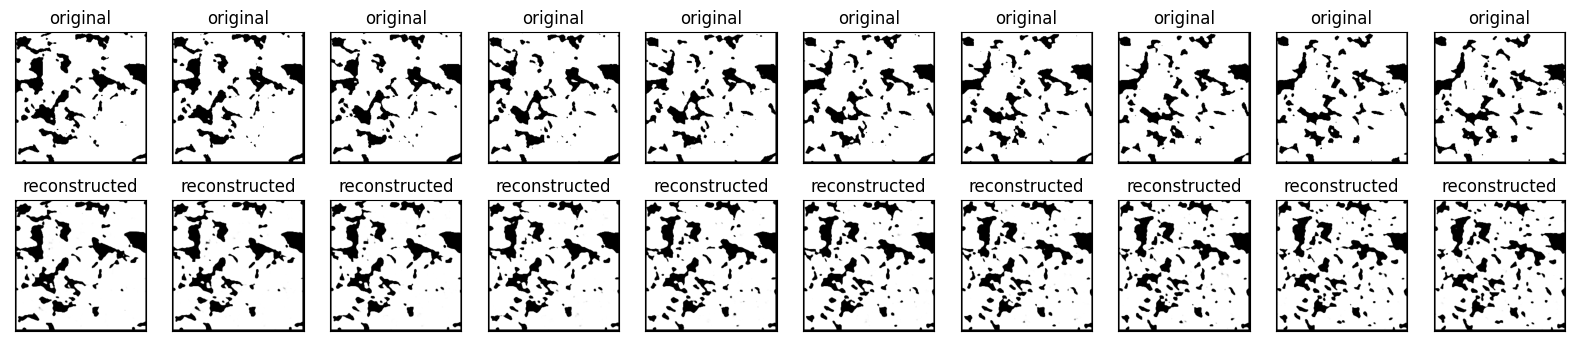

In [14]:
n = 10

plt.figure(figsize=(20,4))
for i in range(n):
    # original
    ax = plt.subplot(2,n,i+1)
    plt.imshow(Topredict[i].astype("float32"))
    plt.title('original')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstructed
    ax = plt.subplot(2,n,i+1+n)
    plt.imshow(testing[i].reshape(256,256,1))
    plt.title('reconstructed')
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [15]:
#from skimage.metrics import mean_squared_error
def porosity(im):
    threshold = 0.5  # Adjust the threshold as needed

    # Calculate the porosity using NumPy operations
    porosity = 1 - np.mean(im <= threshold)
    return porosity

def calculate_mae(list1, list2):
    if len(list1) != len(list2):
        raise ValueError("Both lists must have the same length.")
    
    n = len(list1)
    mae = sum(abs(y1 - y2) for y1, y2 in zip(list1, list2)) / n
    return mae

# def calculate_mse(list1, list2):
#     if len(list1) != len(list2):
#         raise ValueError("Both lists must have the same length.")

#     mse = np.mean([mean_squared_error(img1, img2) for img1, img2 in zip(list1, list2)])
#     return mse

In [21]:
por = [porosity(im) for im in testing]
print(por[:10])

por2 = [porosity(im) for im in Topredict]
print(por2[:10])

[0.77191162109375, 0.77313232421875, 0.7722320556640625, 0.7721405029296875, 0.7705841064453125, 0.7696075439453125, 0.7690582275390625, 0.7677001953125, 0.76556396484375, 0.7638092041015625]
[0.7767791748046875, 0.7809600830078125, 0.7844390869140625, 0.7950897216796875, 0.7989654541015625, 0.7987060546875, 0.798919677734375, 0.8007049560546875, 0.8034820556640625, 0.8024749755859375]


In [25]:
file_path = "testing.npy"
np.save("testing", testing)
# testing.tofile(file_path)

In [ ]:
file_path = "Topredict.npy"
np.save("Topredict", Topredict)
# testing.tofile(file_path)

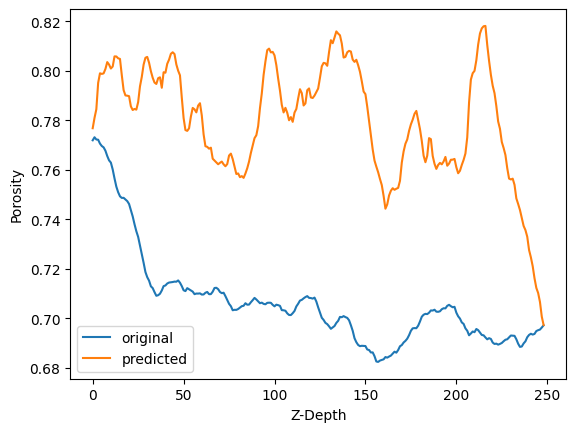

In [17]:
# Create the plot
plt.plot(range(len(testing)), por, label='original')
plt.plot(range(len(testing)), por2, label='predicted')

# Add labels and a legend
plt.xlabel('Z-Depth')
plt.ylabel('Porosity')
plt.legend()

# Display the plot
plt.show()

In [24]:
to_plot = calculate_mae(por,por2)
# Convert the TensorFlow tensor to a NumPy array
with tf.Session() as sess:
    x_np = to_plot.eval()
print(x_np)

# to_plot2 = calculate_mse(por,por2)
# print(to_plot2)

AttributeError: module 'tensorflow' has no attribute 'Session'

In [ ]:
# reconstruction.Generate.save('reconstruction_10batch_10epochs.h5')

In [ ]:
file_path = "reconstructed.raw"
testing.insert(0, first[0].reshape(1,256,256,1))
print(len(testing))

In [ ]:
final = np.array(testing,np.float32).reshape(250,256,256)
final.shape

In [ ]:
file_path = "my_array.npy"
np.save("file", final)
final.tofile(file_path)

In [ ]:
Volume = np.fromfile(file_path, dtype=np.uint8)
Volume = Volume.reshape(250,256,256)
Volume.shape